In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
class PairedImageDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        # Only include image files (filter out directories)
        self.lr_images = sorted([
            f for f in os.listdir(lr_dir)
            if os.path.isfile(os.path.join(lr_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.hr_images = sorted([
            f for f in os.listdir(hr_dir)
            if os.path.isfile(os.path.join(hr_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr = Image.open(lr_path).convert('RGB')
        hr = Image.open(hr_path).convert('RGB')
        if self.transform:
            lr = self.transform(lr)
            hr = self.transform(hr)
        return lr, hr


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
    def forward(self, x):
        return x + self.block(x)

class EDSR(nn.Module):
    def __init__(self, num_blocks=16, channels=64, scale=4):
        super().__init__()
        self.head = nn.Conv2d(3, channels, 3, padding=1)
        self.body = nn.Sequential(*[ResidualBlock(channels) for _ in range(num_blocks)])
        self.tail = nn.Conv2d(channels, 3, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale, mode='bicubic', align_corners=False)
    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        x = self.upsample(x)
        return x

class EDSR_baseline(nn.Module):
    def __init__(self, num_blocks=4, channels=32, scale=4):
        super().__init__()
        self.head = nn.Conv2d(3, channels, 3, padding=1)
        self.body = nn.Sequential(*[ResidualBlock(channels) for _ in range(num_blocks)])
        self.tail = nn.Conv2d(channels, 3, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale, mode='bicubic', align_corners=False)
    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        x = self.upsample(x)
        return x


In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_lr_dir = '/kaggle/input/2k-div2-3x-upscaling-for-image-super-resolution/Training/LR/lr_images'
train_hr_dir = '/kaggle/input/2k-div2-3x-upscaling-for-image-super-resolution/Training/HR/hr_images'
val_lr_dir = '/kaggle/input/2k-div2-3x-upscaling-for-image-super-resolution/Validation/LR/lr_images'
val_hr_dir = '/kaggle/input/2k-div2-3x-upscaling-for-image-super-resolution/Validation/HR/hr_images'


train_dataset = PairedImageDataset(train_lr_dir, train_hr_dir, transform=transform)
val_dataset = PairedImageDataset(val_lr_dir, val_hr_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher = EDSR().to(device)
student = EDSR_baseline().to(device)

In [7]:
def train_teacher(model, loader, epochs=10):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()
    for epoch in range(epochs):
        total_loss = 0
        for lr_imgs, hr_imgs in loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            optimizer.zero_grad()
            sr_imgs = model(lr_imgs)
            loss = loss_fn(sr_imgs, hr_imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Teacher Epoch {epoch+1}: Loss={total_loss/len(loader):.4f}")

train_teacher(teacher, train_loader, epochs=10)

Teacher Epoch 1: Loss=0.1008
Teacher Epoch 2: Loss=0.0474
Teacher Epoch 3: Loss=0.0493
Teacher Epoch 4: Loss=0.0459
Teacher Epoch 5: Loss=0.0441
Teacher Epoch 6: Loss=0.0445
Teacher Epoch 7: Loss=0.0444
Teacher Epoch 8: Loss=0.0442
Teacher Epoch 9: Loss=0.0432
Teacher Epoch 10: Loss=0.0441


In [8]:
def train_kd(teacher, student, loader, epochs=10, alpha=0.5):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()
    for epoch in range(epochs):
        total_loss = 0
        for lr_imgs, hr_imgs in loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            with torch.no_grad():
                teacher_sr = teacher(lr_imgs)
            student_sr = student(lr_imgs)
            loss_gt = loss_fn(student_sr, hr_imgs)
            loss_kd = loss_fn(student_sr, teacher_sr)
            loss = (1 - alpha) * loss_gt + alpha * loss_kd
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"KD Epoch {epoch+1}: Loss={total_loss/len(loader):.4f}")

train_kd(teacher, student, train_loader, epochs=10, alpha=0.5)


KD Epoch 1: Loss=0.0523
KD Epoch 2: Loss=0.0318
KD Epoch 3: Loss=0.0299
KD Epoch 4: Loss=0.0275
KD Epoch 5: Loss=0.0271
KD Epoch 6: Loss=0.0274
KD Epoch 7: Loss=0.0264
KD Epoch 8: Loss=0.0262
KD Epoch 9: Loss=0.0264
KD Epoch 10: Loss=0.0260


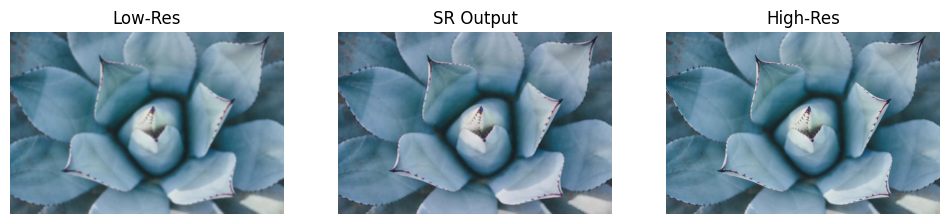

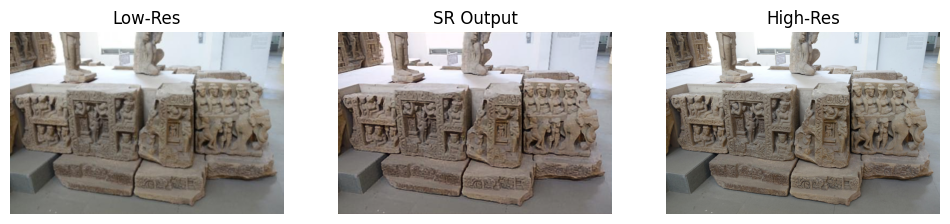

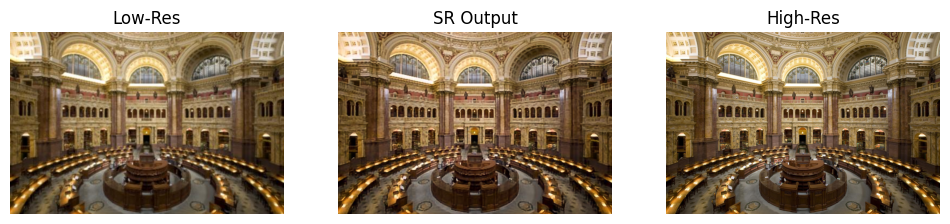

In [9]:
def show_results(model, loader):
    model.eval()
    lr_imgs, hr_imgs = next(iter(loader))
    lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
    with torch.no_grad():
        sr_imgs = model(lr_imgs)
    for i in range(min(3, lr_imgs.size(0))):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(lr_imgs[i].cpu().permute(1,2,0).numpy())
        axs[0].set_title('Low-Res')
        axs[1].imshow(sr_imgs[i].cpu().permute(1,2,0).numpy())
        axs[1].set_title('SR Output')
        axs[2].imshow(hr_imgs[i].cpu().permute(1,2,0).numpy())
        axs[2].set_title('High-Res')
        for ax in axs: ax.axis('off')
        plt.show()

show_results(student, val_loader)

In [22]:
# Save the trained student model
torch.save(student.state_dict(), 'student_sr_model.pth')
print("Model saved as student_sr_model.pth")


Model saved as student_sr_model.pth


In [19]:
import matplotlib.pyplot as plt

def show_results(model, loader, num_batches=1):
    model.eval()
    batch_count = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            for i in range(lr_imgs.size(0)):
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                # Convert tensors: detach, move to cpu, clamp, permute, and convert to numpy
                axs[0].imshow(lr_imgs[i].detach().cpu().clamp(0, 1).permute(1,2,0).numpy())
                axs[0].set_title('Low-Res')
                axs[1].imshow(sr_imgs[i].detach().cpu().clamp(0, 1).permute(1,2,0).numpy())
                axs[1].set_title('SR Output')
                axs[2].imshow(hr_imgs[i].detach().cpu().clamp(0, 1).permute(1,2,0).numpy())
                axs[2].set_title('High-Res')
                for ax in axs: ax.axis('off')
                plt.show()
            batch_count += 1
            if batch_count >= num_batches:
                break


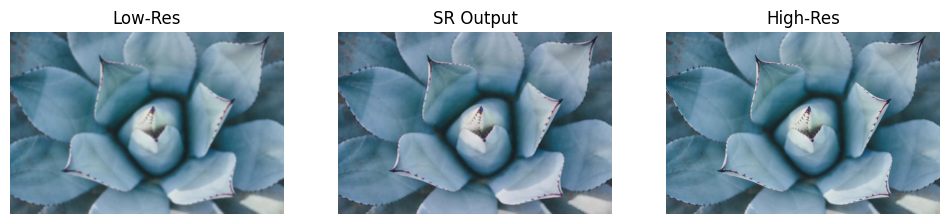

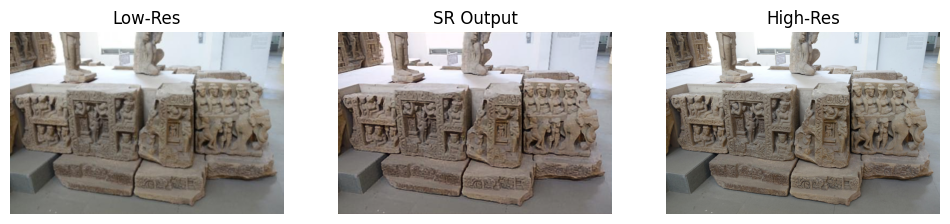

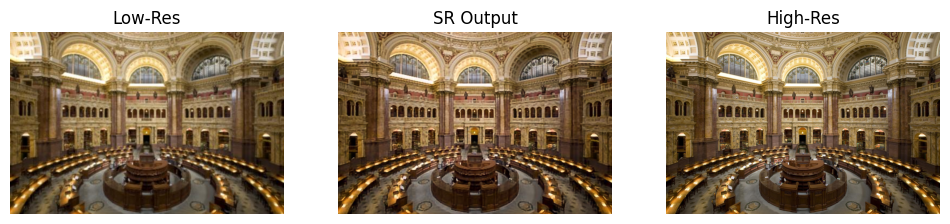

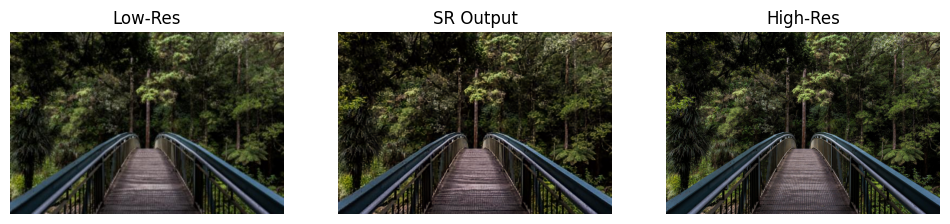

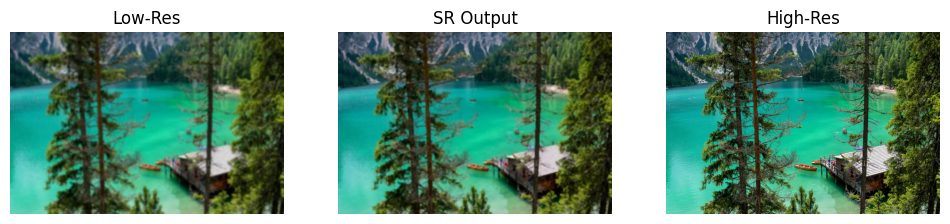

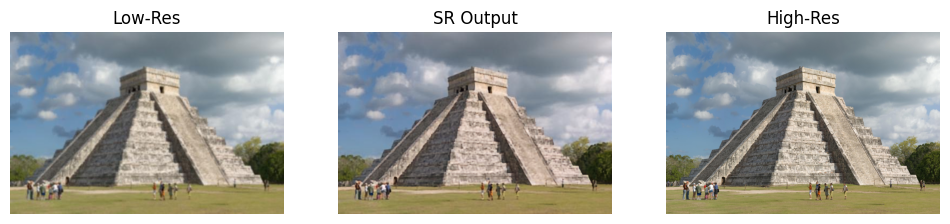

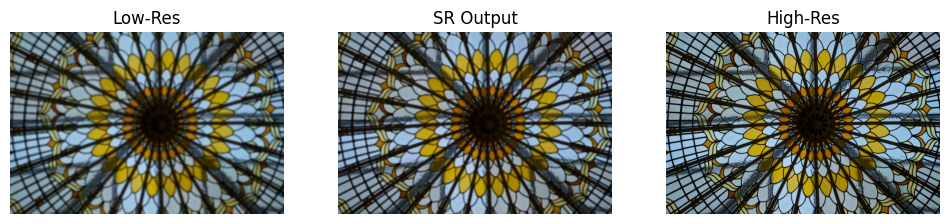

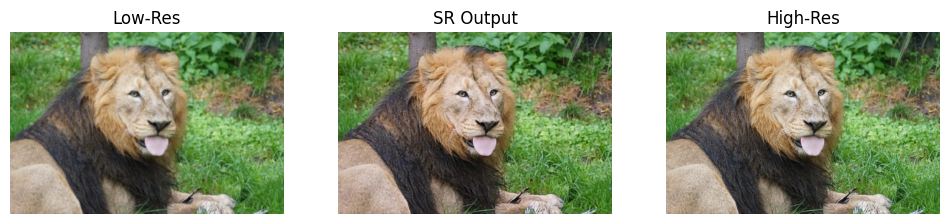

In [20]:
show_results(student, val_loader, num_batches=2)  
